# Notebook for drawing all necessary graphs

## 1. Initialization

### 1a. Imports

In [1]:
import deeptrack, imageGeneration, unet, benchmark
from matplotlib import pyplot as plt

### 1b. Define image parameter functions

In [2]:
from numpy.random import randint, uniform, choice, exponential
from numpy import clip
from math import pi

def get_image_parameters_single_particle(SNR):
    particle_number = choice([0] + [1]*5)
    particle_radius_list = uniform(2, 8, particle_number)
    image_size = 51
    (particle_center_x_list, particle_center_y_list) = imageGeneration.generate_particle_positions(particle_radius_list, image_size)
    image_parameters = {}
    
    particle_bessel_orders_list = []
    particle_intensities_list = []
    
    for i in range(particle_number):
        particle_bessel_orders_list.append([randint(1,3), ])
        particle_intensities_list.append([uniform(0.1, 0.3, 1), ])
    
    
    image_parameters = imageGeneration.get_image_parameters(
        particle_center_x_list=lambda: particle_center_x_list,
        particle_center_y_list=lambda: particle_center_y_list,
        particle_radius_list=lambda: particle_radius_list,
        particle_bessel_orders_list=lambda: particle_bessel_orders_list,
        particle_intensities_list=lambda: particle_intensities_list,
        image_size=lambda: image_size,
        image_background_level=lambda: uniform(0.1, 0.3),
        signal_to_noise_ratio= lambda: SNR,
        gradient_intensity=lambda: uniform(0, 0.4),
        gradient_direction=lambda: uniform(-pi, pi),
        ellipsoidal_orientation=lambda: uniform(-pi, pi, particle_number),
        ellipticity=lambda: 1)
    
    return image_parameters

def get_image_parameters_multiple_particles(SNR, allow_overlap = True):
    from numpy.random import uniform, randint, exponential
    from numpy import ones, clip
    from math import pi
    
    image_size = 256
    
    particle_number = randint(10, 20)
    particle_radius_list = uniform(2, 8, particle_number)
    (particle_center_x_list, particle_center_y_list) = imageGeneration.generate_particle_positions(particle_radius_list, image_size, allow_overlap = allow_overlap)

    particle_bessel_orders_list = []
    particle_intensities_list = []

    for i in range(particle_number):
        particle_bessel_orders_list.append([randint(1,3), ])
        particle_intensities_list.append([uniform(0.1, 0.3, 1), ])

    image_parameters = imageGeneration.get_image_parameters(
        particle_center_x_list=lambda: particle_center_x_list,
        particle_center_y_list=lambda: particle_center_y_list,
        particle_radius_list=lambda: particle_radius_list, 
        particle_bessel_orders_list=lambda: particle_bessel_orders_list,
        particle_intensities_list=lambda: particle_intensities_list,
        image_size=lambda: image_size,
        image_background_level=lambda: uniform(0.1, 0.3),
        signal_to_noise_ratio=lambda: SNR,
        gradient_intensity=lambda: uniform(0, 0.4),
        gradient_direction=lambda: uniform(-pi, pi),
        ellipsoidal_orientation=lambda: uniform(-pi, pi, particle_number),
        ellipticity=lambda: 1)

    return image_parameters

## 2. uTrack vs DeepTrack


### 2a. Single-particle

#### I) MAE and hit percentage as function of SNR

1
[0.7603125]
2
[0.819375]
3
[0.895]
4
[0.8575]
5
[0.9]
6
[0.989375]
7
[0.84]
8
[0.82]
9
[0.95625]
10
[0.885]
20
[0.78]
30
[0.9]
40
[0.84]
50
[0.94]
60
[0.86]
70
[0.8]
80
[0.8]
90
[0.86]
100
[0.8]
200
[0.7825]


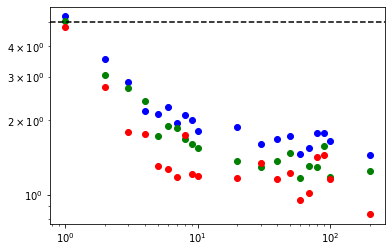

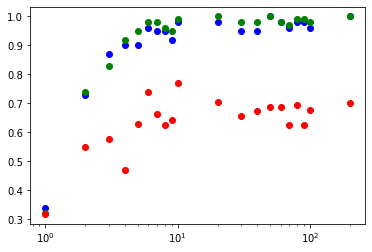

In [10]:
SNRs = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200]
MAEs_deeptrack_single = []
hit_percentages_deeptrack_single = []

MAEs_deeptrack_multi = []
hit_percentages_deeptrack_multi = []

MAEs_unet = []
hit_percentages_unet = []

unet_model = unet.create_unet("Network - uTrack.hdf5")
deeptrack_network_single = deeptrack.load("Network - DeepTrack, single particle.h5")
deeptrack_network_multi = deeptrack.load("Network 2020-04-25-234703 C-16-32-64 D-32-32 training-8x16001-32x12001-128x8001-512x4001-1024x401.h5")

for SNR in SNRs:
    print(SNR)
    
    # Find optimal cutoff by first generating a batch for the current SNR, then finding optimal cutoff on this batch
    batch_for_finding_cutoff = imageGeneration.get_batch(lambda: get_image_parameters_single_particle(SNR), batch_size = 100, suppress_warnings = True, verbose = False)
    (batch_images, batch_labels, batch_predictions, batch_particle_attributes) = batch_for_finding_cutoff
    batch_predictions = unet.predict(unet_model, batch_images)
    optimal_cutoff = benchmark.get_optimal_parameters_unet(batch_predictions,
                                                           batch_particle_attributes,
                                                           51, 51,
                                                           100,
                                                           2,
                                                           0.8,
                                                           1.0)
    print(optimal_cutoff)

    batch = imageGeneration.load_batch(batch_size = 1000, image_path = 'validation/single_particle/images/SNR %d' % SNR, 
                                       label_path = 'validation/single_particle/labels/SNR %d' % SNR,
                                       prediction_path = 'validation/single_particle/predictions/SNR %d' % SNR, 
                                       particle_attributes_path = 'validation/single_particle/particle_attributes/SNR %d' % SNR,
                                       verbose = False)
    
    (batch_images, batch_labels, batch_predictions, batch_particle_attributes) = batch
    
    MAE_unet, hit_percentage_unet = benchmark.unet_single_particle_MAE_and_hits(unet_model, batch_images, batch_particle_attributes, cutoff_value = optimal_cutoff)
    MAEs_unet.append(MAE_unet); hit_percentages_unet.append(hit_percentage_unet)
    
    MAE_deeptrack_single, hit_percentage_deeptrack_single = benchmark.deeptrack_single_particle_MAE_and_hits(deeptrack_network_single, batch_images, batch_particle_attributes, radius_cutoff = 25 * 2 ** (1/2))
    MAEs_deeptrack_single.append(MAE_deeptrack_single); hit_percentages_deeptrack_single.append(hit_percentage_deeptrack_single)
    
    MAE_deeptrack_multi, hit_percentage_deeptrack_multi = benchmark.deeptrack_single_particle_MAE_and_hits(deeptrack_network_multi, batch_images, batch_particle_attributes, radius_cutoff = 25 * 2 ** (1/2))
    MAEs_deeptrack_multi.append(MAE_deeptrack_multi); hit_percentages_deeptrack_multi.append(hit_percentage_deeptrack_multi)

plt.loglog(SNRs, MAEs_deeptrack_single, 'bo')
plt.loglog(SNRs, MAEs_deeptrack_multi, 'go')
plt.loglog(SNRs, MAEs_unet, 'ro')
plt.axhline(5, color = 'black',ls = '--')
plt.show()

plt.plot(SNRs, hit_percentages_deeptrack_single, 'bo')
plt.plot(SNRs, hit_percentages_deeptrack_multi, 'go')
plt.plot(SNRs, hit_percentages_unet, 'ro')
plt.xscale('log')
plt.show()

#### II) Prediction time as a function of batch_size

In [ ]:
import time
#### I) MAE as function of SNR
template = [2,3,4,5,6,7,8,9,10]
batch_sizes = [1]
for power in range(3):
    batch_sizes = batch_sizes + [x * 10**power for x in template]

times_unet = []
unet_model = unet.create_unet("Network - uTrack.hdf5")

times_deeptrack_single = []
deeptrack_network_single = deeptrack.load("Network - DeepTrack, single particle.h5")

for batch_size in batch_sizes:
    batch = imageGeneration.load_batch(batch_size = batch_size, image_path = 'validation/single_particle/images/SNR %d' % SNR, 
                                       label_path = 'validation/single_particle/labels/SNR %d' % SNR,
                                       prediction_path = 'validation/single_particle/predictions/SNR %d' % SNR, 
                                       particle_attributes_path = 'validation/single_particle/particle_attributes/SNR %d' % SNR,
                                       verbose = False)
    
    (batch_images, batch_labels, batch_predictions_after_cutoff, batch_particle_attributes) = batch
    
    time_unet = time.time()
    unet.predict(unet_model, batch_images)
    times_unet.append(time.time() - time_unet)
    
    time_deeptrack = time.time()
    for i in range(batch_size):
        deeptrack.predict(deeptrack_network_single, 
                          batch_images[i, :, :, 0]),
                            times_deeptrack_single.append(time.time() - time_deeptrack)

plt.loglog(batch_sizes, times_unet, 'ro')
plt.loglog(batch_sizes, times_deeptrack_single, 'bo')
import numpy as np
print("Unet is %.4f faster than deeptrack" % (np.polyfit(batch_sizes, times_deeptrack_single, 1)[0] / np.polyfit(batch_sizes, times_unet, 1)[0]))

## 3. uTrack


#### I) MAE(x,y), MAE(r) and MAE(I) as functions of SNR

1
2
3
4
5
6
7
8
9
10
20
30
40
50
60
70
80
90
100
200


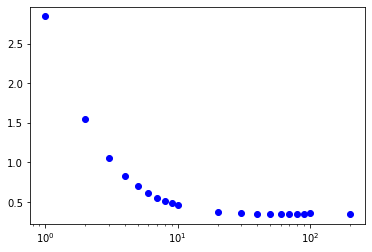

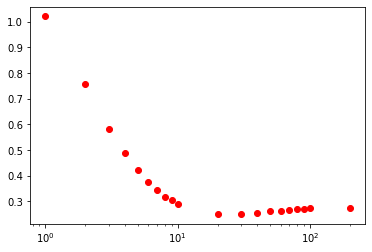

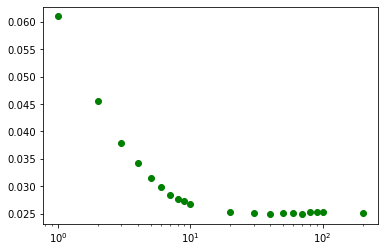

In [9]:
import numpy as np

SNRs = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200]
MAEs_xy = []
MAEs_r = []
MAEs_I = []

unet_model = unet.create_unet("Network - uTrack.hdf5")

for SNR in SNRs:
    print(SNR)   
    batch = imageGeneration.load_batch(batch_size = 1000, image_path = 'validation/multi_particle_no_overlap/images/SNR %d' % SNR, 
                                   label_path = 'validation/multi_particle_no_overlap/labels/SNR %d' % SNR,
                                   prediction_path = 'validation/multi_particle_no_overlap/predictions/SNR %d' % SNR, 
                                   particle_attributes_path = 'validation/multi_particle_no_overlap/particle_attributes/SNR %d' % SNR,
                                   verbose = False)
    
    (batch_images, batch_labels, batch_predictions, batch_particle_attributes) = batch
    
    batch_predictions = unet.predict(unet_model, batch_images)
    
    MAEs_xy.append(benchmark.get_MAE_xy_unet(batch_labels, batch_predictions))
    MAEs_r.append(benchmark.get_MAE_r_unet(batch_labels, batch_predictions))
    MAEs_I.append(benchmark.get_MAE_I_unet(batch_labels, batch_predictions))
    
plt.plot(SNRs, MAEs_xy, 'bo')
plt.xscale('log')
plt.show()
 
plt.plot(SNRs, MAEs_r, 'ro')
plt.xscale('log')
plt.show()

plt.plot(SNRs, MAEs_I, 'go')
plt.xscale('log')
plt.show()


#### I) Precision, recall as functions of SNR 

In [ ]:
import numpy as np
SNRs = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200]
precisions = []
recalls = []

unet_model = unet.create_unet("Network - uTrack.hdf5")

for SNR in SNRs:
    print(SNR)
    # Find optimal cutoff by first generating a batch for the current SNR, then finding optimal cutoff on this batch
    batch_for_finding_cutoff = imageGeneration.get_batch(lambda: get_image_parameters_multiple_particles(SNR), batch_size = 200, suppress_warnings = True, verbose = False)
    (batch_images, batch_labels, batch_predictions, batch_particle_attributes) = batch_for_finding_cutoff
    batch_predictions = unet.predict(unet_model, batch_images)
    optimal_cutoff = benchmark.get_optimal_parameters_unet(batch_predictions,
                                                           batch_particle_attributes,
                                                           256, 256,
                                                           100,
                                                           2,
                                                           0.8,
                                                           1.0)
    print(optimal_cutoff)
    
    (batch_images, batch_labels, batch_predictions, batch_particle_attributes) = batch
    
    batch_predictions = unet.predict(unet_model, batch_images)
    
    batch_predictions_after_cutoff = imageGeneration.cutoff(batch_predictions, cutoff_value = optimal_cutoff, apply_sigmoid = True)
    
    P, N, TP, FP, TN, FN = benchmark.get_operating_characteristics(batch_labels, batch_predictions_after_cutoff)
    
    precisions.append(TP/(TP + FP))
    recalls.append(TP / P)


1
[0.8869043]
2
